In [17]:
import fastai
from fastai.vision.all import *
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from skimage.transform import rescale, resize


In [110]:
def es_correcta(imagen): return imagen[8] == 'B'

In [145]:
path = Path('/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo3/Completo/')


dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.3, bs=3, seed=43,
    label_func=es_correcta
)

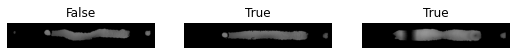

In [147]:
dls.show_batch()

In [5]:
# path = Path('/home/yani/Pruebas TFG/DatasetConIncorrectas/Tipo3/Soldadura_Buena/Dia_1_Pieza_1_Soldadura_77.png')
# image = Image.open(path)
# image = np.asarray(image)
# image_resized = resize(image, (50,100),
#                        anti_aliasing=True)

# plt.imshow(image_resized)


## Depthwise separable convolution
1. https://pytorch.org/docs/0.3.1/nn.html#torch.nn.Conv2d
2. https://programmerclick.com/article/1466208472/#inception%E5%88%B0xception
3. https://www.paepper.com/blog/posts/depthwise-separable-convolutions-in-pytorch/

## Convoluciones en general
1. https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215

## Arquitectura

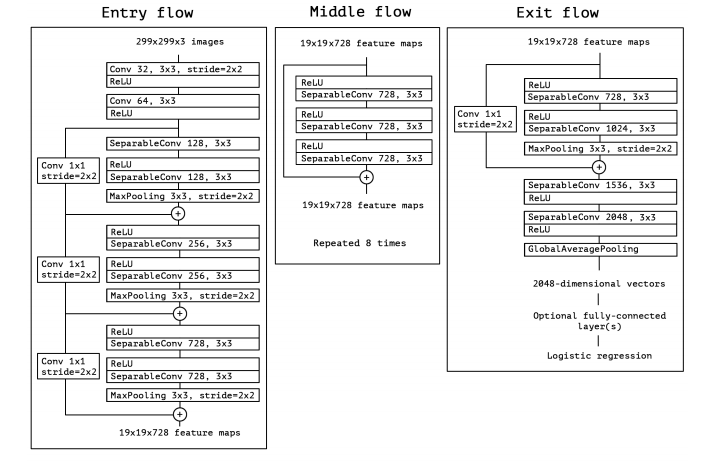

In [112]:
class SeparableConvolution(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size = 3, padding = 1, bias= False):
        super(SeparableConvolution, self).__init__()
        self.depthwise = nn.Conv2d(channels_in, channels_in, kernel_size=kernel_size,
                                   padding=padding, groups=channels_in, bias=bias)
        self.pointwise = nn.Conv2d(channels_in, channels_out, kernel_size=1, bias=bias)
    
    def forward(self, x):
        salida = self.depthwise(x)
        salida = self.pointwise(salida)
        return salida

En este bloque usamos un stride=(1,2) donde 1 es la altura y 2 es la anchura.Esto produce una imagen recortada a la mitad en anchura y se queda con la misma altura.

In [113]:
bloque1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=(1,2)),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())

In [154]:
bloque1.cuda()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
)

In [149]:
batch_im, batch_cat = dls.one_batch()
print(batch_im.shape, batch_cat)

torch.Size([3, 3, 80, 480]) TensorCategory([0, 0, 0], device='cuda:0')


In [150]:
a_imagen = torchvision.transforms.ToPILImage()
primera_imagen = batch_im[0][0]


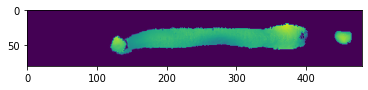

In [151]:
plt.imshow(a_imagen(primera_imagen))

In [155]:
salida_b1 = bloque1(batch_im.cuda())

In [156]:
print(salida_b1.shape)

torch.Size([3, 64, 76, 237])


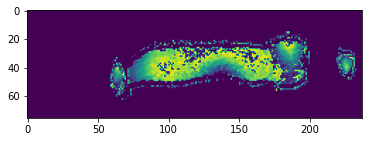

In [161]:
plt.imshow(a_imagen(salida_b1[0][6]))

In [162]:
class ConexionResidual(nn.Module):
    def __init__(self, canales_entrada, canales_salida, stride=1):
        super().__init__()
        self.canales_entrada = canales_entrada
        self.canales_salida = canales_salida
        self.ruta_residual = []
        self.operaciones = nn.Sequential(SeparableConvolution(canales_entrada, canales_salida, kernel_size=3),
                                        nn.BatchNorm2d(canales_salida),
                                        nn.ReLU(),
                                        SeparableConvolution(canales_salida, canales_salida, kernel_size=3),
                                        nn.BatchNorm2d(canales_salida),
                                        nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=False)
                                        )
        
        if canales_entrada != canales_salida:
            self.ruta_residual.extend([nn.Conv2d(canales_entrada, canales_salida,
                                      kernel_size=1,stride=2, padding=0, bias=False),
                           nn.BatchNorm2d(canales_salida)])
            
        self.ruta_residual.extend([nn.AvgPool2d(kernel_size = 2, stride=stride, ceil_mode=True)])
        self.ruta_residual = nn.Sequential(*self.ruta_residual)
    def forward(self, entrada):
        a = self.operaciones(entrada)
        b = self.ruta_residual(entrada)
        print(f'La ruta principal {a.shape} y la residual {b.shape}')
        return a.add_(b)

In [163]:
entrada_residual = salida_b1

In [164]:
res = ConexionResidual(64,128)
res.cuda()
salida_residual = res(entrada_residual.cuda())

La ruta principal torch.Size([3, 128, 37, 118]) y la residual torch.Size([3, 128, 37, 118])


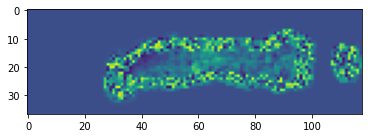

In [173]:
plt.imshow(a_imagen(salida_residual[0][1]))

In [174]:
entry_flow = nn.Sequential(bloque1,
                          ConexionResidual(64,128),
                          ConexionResidual(128,256),
                          ConexionResidual(256,728))

In [182]:
class ConexionResDirecta(nn.Module):
    def __init__(self, canales_entrada, canales_salida, kernel_size=3):
        super().__init__()
        self.canales_entrada = canales_entrada
        self.canales_salida = canales_salida
        self.operaciones = nn.Sequential(nn.ReLU(),
                                        SeparableConvolution(canales_entrada, canales_salida, kernel_size),
                                        nn.BatchNorm2d(canales_salida),
                                        nn.ReLU(),
                                        SeparableConvolution(canales_salida, canales_salida),
                                        nn.BatchNorm2d(canales_salida),
                                        nn.ReLU(),
                                        SeparableConvolution(canales_salida, canales_salida),
                                        nn.BatchNorm2d(canales_salida))
    def forward(self, entrada):
        x = self.operaciones(entrada)
        return entrada.add_(x)

In [183]:
middle_flow = nn.Sequential(ConexionResDirecta(728,728),
                           ConexionResDirecta(728,728),
                           ConexionResDirecta(728,728),
                           ConexionResDirecta(728,728),
                           ConexionResDirecta(728,728),
                           ConexionResDirecta(728,728),
                           ConexionResDirecta(728,728),
                           ConexionResDirecta(728,728))

In [190]:
exit_flow = nn.Sequential()